In [1]:
!git clone https://github.com/darshan154/data.git

Cloning into 'data'...
remote: Enumerating objects: 1972, done.
remote: Counting objects: 100% (1972/1972), done.
remote: Compressing objects: 100% (1970/1970), done.
remote: Total 1972 (delta 9), reused 1963 (delta 0), pack-reused 0
Receiving objects: 100% (1972/1972), 4.66 MiB | 4.07 MiB/s, done.
Resolving deltas: 100% (9/9), done.


In [2]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
# from tensorflow.keras.utils import to_categorical, plot_model
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
# from tensorflow.keras import backend as K
# from sklearn.model_selection import train_test_split
# from tensorflow.keras import callbacks
from numpy import asarray
from sklearn import metrics
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import os
import glob

In [3]:
train_file = []
for filename in glob.glob(r"./data/occ240/occupation/train/" + "/**/*", recursive=True): #assuming gif
    # im=Image.open(filename)
    train_file.append(filename)

test_file = []
for filename in glob.glob(r"./data/occ240/occupation/test/" + "/**/*", recursive=True): #assuming gif
    # im=Image.open(filename)
    test_file.append(filename)

In [4]:
random.shuffle(train_file)
# random.shuffle(test_file)
print(len(train_file))

1205


In [5]:
label = {"doctor":0, "news":1, "player":2, "police":3, "teachers": 4}

In [6]:
trainx = []
testx = []
trainy = []
testy = []

for img in train_file:
  try:
    image = cv2.imread(img)
    image = cv2.resize(image, (64, 64))
    image = img_to_array(image)
    trainx.append(image)

    lbl = img.split(os.path.sep)[-2] # C:\Files\gender_dataset_face\woman\face_1162.jpg
    l = label[lbl]
        
    trainy.append([l]) # [[1], [0], [0], ...]

  except:
    print("Corrupt")
    

for img in test_file:
  try:
    image = cv2.imread(img)
    image = cv2.resize(image, (64, 64))
    image = img_to_array(image)
    testx.append(image)

    lbl = img.split(os.path.sep)[-2] # C:\Files\gender_dataset_face\woman\face_1162.jpg
    l = label[lbl]
        
    # trainy.append([l])
        
    testy.append([l]) # [[1], [0], [0], ...]
  except:
    print("Corrupt")

Corrupt
Corrupt
Corrupt
Corrupt
Corrupt
Corrupt
Corrupt
Corrupt
Corrupt
Corrupt


In [7]:
trainx = np.array(trainx, dtype="float")/255.0
testx = np.array(testx, dtype="float")/255.0

In [8]:
trainx.shape

(1200, 64, 64, 3)

In [9]:
# # example of tending the vgg16 model
import keras
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense
from keras.layers import MaxPooling2D
from keras.layers import Flatten
import math
# load model without classifier layers
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(64, 64, 3))

win1 = math.ceil(16/1)
str1 = math.floor(16/1)

win2 = math.ceil(16/2)
str2 = math.floor(16/2)

win3 = math.ceil(16/4)
str3 = math.floor(16/4)

# win4 = math.ceil(16/8)
# str4 = math.floor(16/8)

l1 = keras.layers.MaxPooling2D(pool_size=(win1), strides=str1, padding="valid")(base_model.layers[-10].output)
l2 = keras.layers.MaxPooling2D(pool_size=(win2), strides=str2, padding="valid")(base_model.layers[-10].output)
l3 = keras.layers.MaxPooling2D(pool_size=(win3), strides=str3, padding="valid")(base_model.layers[-10].output)
# l4 = keras.layers.MaxPooling2D(pool_size=(win4), strides=str4, padding="valid")(base_model.layers[-10].output)



flat1 = Flatten()(l1)
flat2 = Flatten()(l2)
flat3 = Flatten()(l3)
# flat4 = Flatten()(l4)

# class1 = Dense(4096, activation='relu')(flat1)
# # define new model

for layer in base_model.layers:
    layer.trainable = False


model = Model(inputs=base_model.inputs, outputs=[flat1, flat2, flat3])

# combined = np.concatenate([b1.output, b2.output, b3.output])

58900480/58889256 [==============================] - 2s 0us/step


In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 64, 64, 64)   1792        ['input_1[0][0]']                
                                                                                                  
 block1_conv2 (Conv2D)          (None, 64, 64, 64)   36928       ['block1_conv1[0][0]']           
                                                                                                  
 block1_pool (MaxPooling2D)     (None, 32, 32, 64)   0           ['block1_conv2[0][0]']           
                                                                                              

In [11]:
trainy = np.array(trainy)
testy = np.array(testy)

In [12]:
train = model.predict(trainx)
test = model.predict(testx)

train = np.hstack([train[0], train[1], train[2]])
test = np.hstack([test[0], test[1], test[2]])

In [13]:
from sklearn.linear_model import LogisticRegression  

clf=LogisticRegression()

In [14]:
train.shape

(1200, 5376)

In [15]:
clfmodel = clf.fit(train, trainy)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [16]:
y_pred = clfmodel.predict(test)

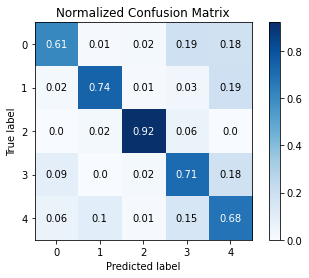

In [17]:
!pip install scikit-plot
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import scikitplot as skplt
#Normalized confusion matrix for the K-NN model
skplt.metrics.plot_confusion_matrix(testy, y_pred, normalize=True)
plt.show()

In [18]:
# accuracy 73.2